# Part 1 : GW Waveform Zoo - Calling Native Implementations + Benchmarks

This notebook demonstrates how to generate gravitational-wave signals from **native implementations** and compare both **signal morphology** and **generation times**. It covers models from:

- **LALSuite / lalsimulation** (via `PyCBC`): TaylorF2/F2Ecc, SpinTaylorT4, IMRPhenom* (XAS/XHM/XP/XPHM), SEOBNRv4/v4HM, SEOBNRv4_ROM, tidal models (IMRPhenomD/XP + NRTidalv2), and SEOBNRv4T_surrogate.
- **pySEOBNR**: SEOBNRv5HM, SEOBNRv5PHM, SEOBNRv5EHM.
- **TEOBResumS**: EOBRun python bindings.
- **GWSurrogate**: NRSur7dq4 and NRHybSur3dq8.

> ⚠️ **Note**  
> The notebook detects what is available in your environment and *skips gracefully* when a package/model is not installed.  
> You can run this in **Colab** (recommended for a quick start) or on a local machine using **Jupyter Notebook** (recommended) or a remote cluster with conda.


In [1]:
# --- Setup (run this cell first) ----------------------------------------------
import sys, subprocess, importlib

def _pip_install(pkgs):
    print("Installing with pip:", pkgs)
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + pkgs)

# Minimal always
try:
    import numpy, matplotlib, pycbc
except Exception:
    _pip_install(["numpy", "matplotlib", "pycbc"])

# Surrogates + extras
for pkg in ["gwsurrogate", "teobresums", "pyseobnr"]:
    try:
        importlib.import_module(pkg)
    except Exception as e:
        print(f"{pkg} not importable yet: {e}")
        try:
            _pip_install([pkg])
        except Exception as ie:
            print(f"pip install of {pkg} failed. You can install it later with conda/pip. Skipping for now.")

print("Environment ready (some optional packages may be missing; the notebook will skip them).")


Installing with pip: ['numpy', 'matplotlib', 'pycbc']
gwsurrogate not importable yet: No module named 'gwsurrogate'
Installing with pip: ['gwsurrogate']


  error: subprocess-exited-with-error
  
  × Building wheel for gwsurrogate (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [197 lines of output]
      /private/var/folders/dj/md5_z2ld46dd1mgqd9zgfrl40000gn/T/pip-build-env-4ekts_ow/overlay/lib/python3.13/site-packages/setuptools/_distutils/dist.py:289: UserWarning: Unknown distribution option: 'contributors'
        warnings.warn(msg)
      /private/var/folders/dj/md5_z2ld46dd1mgqd9zgfrl40000gn/T/pip-build-env-4ekts_ow/overlay/lib/python3.13/site-packages/setuptools/dist.py:759: SetuptoolsDeprecationWarning: License classifiers are deprecated.
      !!
      
              ********************************************************************************
              Please consider removing the following classifiers in favor of a SPDX license expression:
      
              License :: OSI Approved :: MIT License
      
              See https://packaging.python.org/en/latest/guides/writing-pyproject-toml/#license for

pip install of gwsurrogate failed. You can install it later with conda/pip. Skipping for now.
teobresums not importable yet: No module named 'teobresums'
Installing with pip: ['teobresums']


  error: subprocess-exited-with-error
  
  × Building wheel for teobresums (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [32 lines of output]
      /private/var/folders/dj/md5_z2ld46dd1mgqd9zgfrl40000gn/T/pip-build-env-zdmko1rr/overlay/lib/python3.13/site-packages/setuptools/config/_apply_pyprojecttoml.py:61: SetuptoolsDeprecationWarning: License classifiers are deprecated.
      !!
      
              ********************************************************************************
              Please consider removing the following classifiers in favor of a SPDX license expression:
      
              License :: OSI Approved :: GNU General Public License v3 (GPLv3)
      
              See https://packaging.python.org/en/latest/guides/writing-pyproject-toml/#license for details.
              ********************************************************************************
      
      !!
        dist._finalize_license_expression()
      /private/var/folders/dj/m

pip install of teobresums failed. You can install it later with conda/pip. Skipping for now.
pyseobnr not importable yet: No module named 'pyseobnr'
Installing with pip: ['pyseobnr']


  error: subprocess-exited-with-error
  
  × Building wheel for pygsl_lite (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [80 lines of output]
      /private/var/folders/dj/md5_z2ld46dd1mgqd9zgfrl40000gn/T/pip-build-env-risltsk2/overlay/lib/python3.13/site-packages/setuptools/config/_apply_pyprojecttoml.py:82: SetuptoolsDeprecationWarning: `project.license` as a TOML table is deprecated
      !!
      
              ********************************************************************************
              Please use a simple string containing a SPDX expression for `project.license`. You can also use `project.license-files`. (Both options available on setuptools>=77.0.0).
      
              By 2026-Feb-18, you need to update your project and remove deprecated calls
              or your builds will no longer be supported.
      
              See https://packaging.python.org/en/latest/guides/writing-pyproject-toml/#license for details.
              ************

pip install of pyseobnr failed. You can install it later with conda/pip. Skipping for now.
Environment ready (some optional packages may be missing; the notebook will skip them).


In [3]:
# --- Imports & helpers ---------------------------------------------------------
import numpy as np
import time, warnings, importlib
import matplotlib.pyplot as plt

from pycbc.waveform import get_td_waveform, get_fd_waveform, td_approximants, fd_approximants
from pycbc.types import TimeSeries, FrequencySeries
from pycbc import fft

try:
    import gwsurrogate as gws
except Exception:
    gws = None

try:
    from pyseobnr.generate_waveform import GenerateWaveform as _PSEOB_GW
except Exception:
    _PSEOB_GW = None

try:
    import EOBRun_module as _EOB
except Exception:
    _EOB = None

warnings.filterwarnings("ignore")

DEFAULTS = dict(
    delta_t = 1.0/4096.0,
    delta_f = 1.0/16.0,
    f_lower = 20.0,
    f_ref   = 20.0,
    distance= 400.0,        # Mpc
    inclination = 0.7,      # radians
    coa_phase = 0.0,
)

rng = np.random.default_rng(17)

def rand_aligned_bbhs():
    m1 = rng.uniform(20, 60); m2 = rng.uniform(10, min(50, m1))
    chi1z = rng.uniform(-0.9, 0.9); chi2z = rng.uniform(-0.9, 0.9)
    return dict(mass1=m1, mass2=m2, spin1z=chi1z, spin2z=chi2z)

def rand_precessing_bbhs():
    m1 = rng.uniform(20, 60); m2 = rng.uniform(10, min(50, m1))
    def rand_spin():
        a = rng.uniform(0, 0.9)
        theta = rng.uniform(0, np.pi); phi = rng.uniform(0, 2*np.pi)
        return a*np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])
    s1 = rand_spin(); s2 = rand_spin()
    return dict(mass1=m1, mass2=m2,
                spin1x=float(s1[0]), spin1y=float(s1[1]), spin1z=float(s1[2]),
                spin2x=float(s2[0]), spin2y=float(s2[1]), spin2z=float(s2[2]))

def rand_bns_tidal():
    m1 = rng.uniform(1.2, 1.7); m2 = rng.uniform(1.1, min(1.6, m1))
    lam1 = float(rng.uniform(100, 1200)); lam2 = float(rng.uniform(100, 1200))
    return dict(mass1=m1, mass2=m2, lambda1=lam1, lambda2=lam2)

def rand_eccentric_bbh():
    base = rand_aligned_bbhs()
    base["eccentricity"] = float(rng.uniform(0.05, 0.25))
    base["mean_per_ano"] = float(rng.uniform(0, 2*np.pi))
    return base

def ts_from_fd(hf: FrequencySeries, delta_t: float) -> TimeSeries:
    flen = len(hf)
    tlen = int(1.0 / delta_t / hf.delta_f)
    hf = hf.copy(); hf.resize(tlen//2 + 1)
    ts = TimeSeries(np.zeros(tlen, dtype=np.complex128), delta_t=delta_t)
    fft.ifft(hf, ts)
    return ts

def call_pycbc(approximant: str, params: dict, domain_hint: str = "auto"):
    aps_td = set(map(str, td_approximants())); aps_fd = set(map(str, fd_approximants()))
    p = dict(DEFAULTS); p.update(params); p["approximant"] = approximant
    if domain_hint == "time" or (domain_hint=="auto" and approximant in aps_td):
        hp, hc = get_td_waveform(**p)
        return np.array(hp.sample_times), np.array(hp.numpy()), np.array(hc.numpy())
    elif domain_hint == "freq" or (domain_hint=="auto" and approximant in aps_fd):
        hpf, hcf = get_fd_waveform(**{k:v for k,v in p.items() if k!="delta_t"})
        hp = ts_from_fd(hpf, p["delta_t"]); hc = ts_from_fd(hcf, p["delta_t"])
        return np.array(hp.sample_times), np.array(hp.numpy()), np.array(hc.numpy())
    else:
        raise RuntimeError(f"Approximant {approximant} not found in pycbc (td or fd).")

def call_pyseobnr(approximant: str, params: dict):
    if _PSEOB_GW is None:
        raise RuntimeError("pyseobnr not available.")
    p = {
        "mass1": params.get("mass1", 30.0), "mass2": params.get("mass2", 20.0),
        "spin1x": params.get("spin1x", 0.0), "spin1y": params.get("spin1y", 0.0), "spin1z": params.get("spin1z", 0.5),
        "spin2x": params.get("spin2x", 0.0), "spin2y": params.get("spin2y", 0.0), "spin2z": params.get("spin2z", 0.8),
        "deltaT": params.get("delta_t", DEFAULTS["delta_t"]),
        "f22_start": params.get("f_lower", DEFAULTS["f_lower"]),
        "phi_ref": params.get("coa_phase", DEFAULTS["coa_phase"]),
        "distance": params.get("distance", DEFAULTS["distance"]),
        "inclination": params.get("inclination", DEFAULTS["inclination"]),
        "f_max": params.get("f_max", 1024.0),
        "approximant": approximant,
    }
    wfm = _PSEOB_GW(p)
    t, modes = wfm.generate_td_modes()
    hp, hc = wfm.generate_td_polarizations()
    return np.array(t), np.array(hp.numpy()), np.array(hc.numpy())

def call_teobresums(params: dict):
    if _EOB is None:
        raise RuntimeError("teobresums (EOBRun_module) not available.")
    p = dict(
        domain = 0,
        q = params.get("mass1", 30.0) / params.get("mass2", 20.0),
        chi1 = params.get("spin1z", 0.0),
        chi2 = params.get("spin2z", 0.0),
        eccentricity = params.get("eccentricity", 0.0),
        initial_frequency = params.get("f_lower", DEFAULTS["f_lower"]),
        use_geometric_units = "no",
        srate_interp = 1.0/params.get("delta_t", DEFAULTS["delta_t"]),
        interp_uniform_grid = "yes",
        use_mode_lm = [1],
        arg_out = "yes"
    )
    t, rhp, ihp, hlm, dyn = _EOB.EOBRunPy(p)
    hp = rhp - 1j*ihp
    hc = np.imag(hp)  # quick-look
    return np.array(t), np.real(hp), np.real(hc)

def call_gwsurrogate(name: str, params: dict):
    if gws is None:
        raise RuntimeError("gwsurrogate not available.")
    surr = gws.LoadSurrogate(name)
    m1 = params.get("mass1", 40.0); m2 = params.get("mass2", 30.0)
    q = m1 / m2
    s1 = np.array([params.get("spin1x", 0.0), params.get("spin1y", 0.0), params.get("spin1z", 0.8)])
    s2 = np.array([params.get("spin2x", 0.0), params.get("spin2y", 0.0), params.get("spin2z", 0.3)])
    f_low = params.get("f_lower", DEFAULTS["f_lower"])
    t, hdict = surr(q=q, chiA=s1, chiB=s2, f_low=f_low, dt=params.get("delta_t", DEFAULTS["delta_t"]))
    h22 = hdict[(2,2)]
    hp = h22.real; hc = h22.imag
    return np.array(t), np.array(hp), np.array(hc)

def plot_overlay(waveforms, xlim=None, title="Time-domain $h_+$ (normalized)"):
    plt.figure(figsize=(9,5))
    for label, (t, hp, hc) in waveforms.items():
        scale = np.max(np.abs(hp)) if np.max(np.abs(hp))>0 else 1.0
        plt.plot(t, hp/scale, label=label)
    if xlim:
        plt.xlim(*xlim)
    plt.xlabel("Time [s]"); plt.ylabel("Normalized strain $h_+$"); plt.legend(loc="best"); plt.grid(True); plt.title(title)
    plt.show()

def benchmark(generator_fn, param_sampler, n=8, name="model"):
    times = []
    for _ in range(n):
        p = param_sampler()
        t0 = time.perf_counter()
        try:
            _ = generator_fn(p)
        except Exception as e:
            return {"name": name, "ok": False, "n": 0, "mean_s": np.nan, "err": str(e)}
        times.append(time.perf_counter() - t0)
    return {"name": name, "ok": True, "n": n, "mean_s": float(np.mean(times)), "std_s": float(np.std(times))}


### Waveform implementations map (overview)
If available, the figure below provides a visual map of major waveform families.

In [ ]:
from IPython.display import Image, display
img_path = "/mnt/data/waveform-approximants-map-plot.png"
import os
if os.path.exists(img_path):
    display(Image(filename=img_path, width=900))
else:
    print("Map image not found in this runtime (optional).")


## Examples (10–15 waveform families)

> **How to use**: Run each cell; models that are unavailable in your environment will be skipped with a clear message.
We generate signals starting at ~20 Hz with a 4096 Hz default sampling rate.


In [ ]:
# --- Define a registry of examples --------------------------------------------
EXAMPLES = []

# 1) PN / inspiral-only families
EXAMPLES.append(("TaylorF2 (FD)", 
                 lambda p: call_pycbc("TaylorF2", {**p}), 
                 rand_bns_tidal))

EXAMPLES.append(("SpinTaylorT4 (TD precessing PN)",
                 lambda p: call_pycbc("SpinTaylorT4", {**p}),
                 rand_precessing_bbhs))

EXAMPLES.append(("TaylorF2Ecc (FD eccentric PN)",
                 lambda p: call_pycbc("TaylorF2Ecc", {**p}),
                 rand_eccentric_bbh))

In [ ]:
# 2) Phenom X family
EXAMPLES.append(("IMRPhenomD (TD)",
                 lambda p: call_pycbc("IMRPhenomD", {**p}),
                 rand_aligned_bbhs))

EXAMPLES.append(("IMRPhenomXAS (FD/TD)",
                 lambda p: call_pycbc("IMRPhenomXAS", {**p}),
                 rand_aligned_bbhs))

EXAMPLES.append(("IMRPhenomXHM (higher modes)",
                 lambda p: call_pycbc("IMRPhenomXHM", {**p, "mode_array":[(2,2),(3,3),(4,4),(2,1)]}),
                 rand_aligned_bbhs))

EXAMPLES.append(("IMRPhenomXP (precessing)",
                 lambda p: call_pycbc("IMRPhenomXP", {**p}),
                 rand_precessing_bbhs))

EXAMPLES.append(("IMRPhenomXPHM (precessing + HMs)",
                 lambda p: call_pycbc("IMRPhenomXPHM", {**p}),
                 rand_precessing_bbhs))

In [ ]:
# 3) Tidal Phenom
EXAMPLES.append(("IMRPhenomD_NRTidalv2 (BNS tides)",
                 lambda p: call_pycbc("IMRPhenomD_NRTidalv2", {**p}),
                 rand_bns_tidal))

EXAMPLES.append(("IMRPhenomXP_NRTidalv2 (precessing BNS tides)",
                 lambda p: call_pycbc("IMRPhenomXP_NRTidalv2", {**p}),
                 rand_bns_tidal))

In [ ]:
# 4) SEOBNR v4 family
EXAMPLES.append(("SEOBNRv4 (TD EOB)",
                 lambda p: call_pycbc("SEOBNRv4", {**p}),
                 rand_aligned_bbhs))

EXAMPLES.append(("SEOBNRv4HM (TD EOB with HMs)",
                 lambda p: call_pycbc("SEOBNRv4HM", {**p}),
                 rand_aligned_bbhs))

EXAMPLES.append(("SEOBNRv4_ROM (FD ROM)",
                 lambda p: call_pycbc("SEOBNRv4_ROM", {**p}),
                 rand_aligned_bbhs))

EXAMPLES.append(("SEOBNRv4T_surrogate (FD tides)",
                 lambda p: call_pycbc("SEOBNRv4T_surrogate", {**p}),
                 rand_bns_tidal))

In [ ]:
# 5) pySEOBNR v5
if _PSEOB_GW is not None:
    EXAMPLES.append(("pySEOBNR: SEOBNRv5HM (TD)",
                     lambda p: call_pyseobnr("SEOBNRv5HM", {**p}),
                     rand_aligned_bbhs))
    EXAMPLES.append(("pySEOBNR: SEOBNRv5PHM (TD, precessing)",
                     lambda p: call_pyseobnr("SEOBNRv5PHM", {**p}),
                     rand_precessing_bbhs))
    EXAMPLES.append(("pySEOBNR: SEOBNRv5EHM (TD, eccentric aligned)",
                     lambda p: call_pyseobnr("SEOBNRv5EHM", {**p, "eccentricity":0.1}),
                     rand_aligned_bbhs))

In [ ]:
# 6) TEOBResumS
if _EOB is not None:
    EXAMPLES.append(("TEOBResumS (aligned-spin TD)",
                     lambda p: call_teobresums({**p}),
                     rand_aligned_bbhs))

# 7) GWSurrogate
if gws is not None:
    EXAMPLES.append(("GWSurrogate: NRSur7dq4 (precessing NR surrogate)",
                     lambda p: call_gwsurrogate("NRSur7dq4", {**p}),
                     rand_precessing_bbhs))
    EXAMPLES.append(("GWSurrogate: NRHybSur3dq8 (aligned-spin surrogate)",
                     lambda p: call_gwsurrogate("NRHybSur3dq8", {**p}),
                     rand_aligned_bbhs))

len(EXAMPLES), [name for name,_,_ in EXAMPLES]


(14,
 ['TaylorF2 (FD)',
  'SpinTaylorT4 (TD precessing PN)',
  'TaylorF2Ecc (FD eccentric PN)',
  'IMRPhenomD (TD)',
  'IMRPhenomXAS (FD/TD)',
  'IMRPhenomXHM (higher modes)',
  'IMRPhenomXP (precessing)',
  'IMRPhenomXPHM (precessing + HMs)',
  'IMRPhenomD_NRTidalv2 (BNS tides)',
  'IMRPhenomXP_NRTidalv2 (precessing BNS tides)',
  'SEOBNRv4 (TD EOB)',
  'SEOBNRv4HM (TD EOB with HMs)',
  'SEOBNRv4_ROM (FD ROM)',
  'SEOBNRv4T_surrogate (FD tides)'])

XLAL Error - SEOBNRv4ROM_Init_LALDATA (LALSimIMRSEOBNRv4ROM.c:1667): Unable to resolve data file 'SEOBNRv4ROM_v3.0.hdf5' in $LAL_DATA_PATH.
Note: LALSuite versions >= 7.25 require data files that are publicly available at:
https://git.ligo.org/waveforms/software/lalsuite-waveform-data
and on Zenodo at: https://zenodo.org/records/14999310.
For earlier LALSuite versions, use the files in lalsuite-extra, available at:
https://git.ligo.org/lscsoft/lalsuite-extra

XLAL Error - SEOBNRv4ROM_Init_LALDATA (LALSimIMRSEOBNRv4ROM.c:1667): I/O error
XLAL Error - SEOBNRv4ROMTimeFrequencySetup (LALSimIMRSEOBNRv4ROM.c:1333): Error setting up SEOBNRv4ROM data - check your $LAL_DATA_PATH

XLAL Error - SEOBNRv4ROMTimeFrequencySetup (LALSimIMRSEOBNRv4ROM.c:1333): Generic failure
XLAL Error - XLALSimIMRSEOBNRv4ROMTimeOfFrequency (LALSimIMRSEOBNRv4ROM.c:1483): Internal function call failed: Generic failure
XLAL Error - Surrogate_Init_LALDATA (LALSimIMRSEOBNRv4TSurrogate.c:1304): Unable to resolve data file 

Generated 11 models; skipped 3.
Skipped (reason):
  - TaylorF2Ecc (FD eccentric PN) : For C2C IFFT, len(invec) must be nbatch*size
  - SEOBNRv4_ROM (FD ROM) : Internal function call failed: Generic failure
  - SEOBNRv4T_surrogate (FD tides) : Internal function call failed: Generic failure


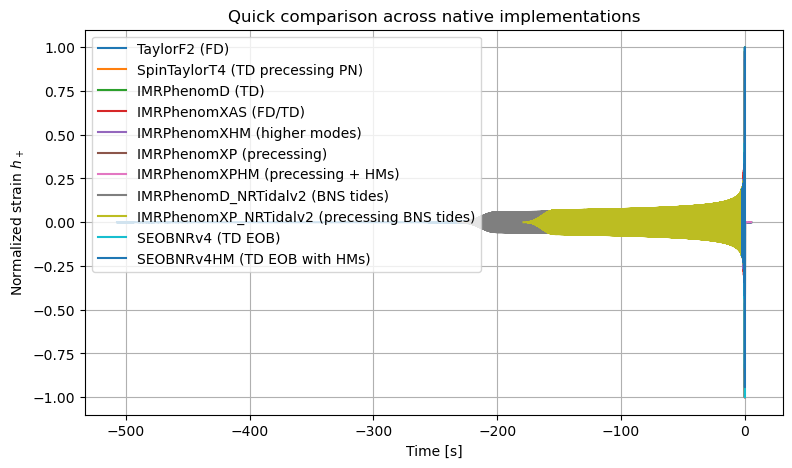

In [5]:
# --- Generate and overlay a selection (one random draw per model) --------------
demo = {}
skipped = []

for name, gen, sampler in EXAMPLES:
    try:
        t, hp, hc = gen(sampler())
        demo[name] = (t, hp, hc)
    except Exception as e:
        skipped.append((name, str(e)))

print(f"Generated {len(demo)} models; skipped {len(skipped)}.")
if skipped:
    print("Skipped (reason):")
    for s in skipped:
        print("  -", s[0], ":", s[1])

plot_overlay(demo, title="Quick comparison across native implementations")


XLAL Error - SEOBNRv4ROMTimeFrequencySetup (LALSimIMRSEOBNRv4ROM.c:1333): Error setting up SEOBNRv4ROM data - check your $LAL_DATA_PATH

XLAL Error - SEOBNRv4ROMTimeFrequencySetup (LALSimIMRSEOBNRv4ROM.c:1333): Generic failure
XLAL Error - XLALSimIMRSEOBNRv4ROMTimeOfFrequency (LALSimIMRSEOBNRv4ROM.c:1483): Internal function call failed: Generic failure
XLAL Error - SurrogateCore (LALSimIMRSEOBNRv4TSurrogate.c:777): Error setting up Surrogate data - check your $LAL_DATA_PATH

XLAL Error - SurrogateCore (LALSimIMRSEOBNRv4TSurrogate.c:777): Generic failure
XLAL Error - XLALSimInspiralChooseFDWaveform_legacy (LALSimInspiralGeneratorLegacy.c:2786): Internal function call failed: Generic failure


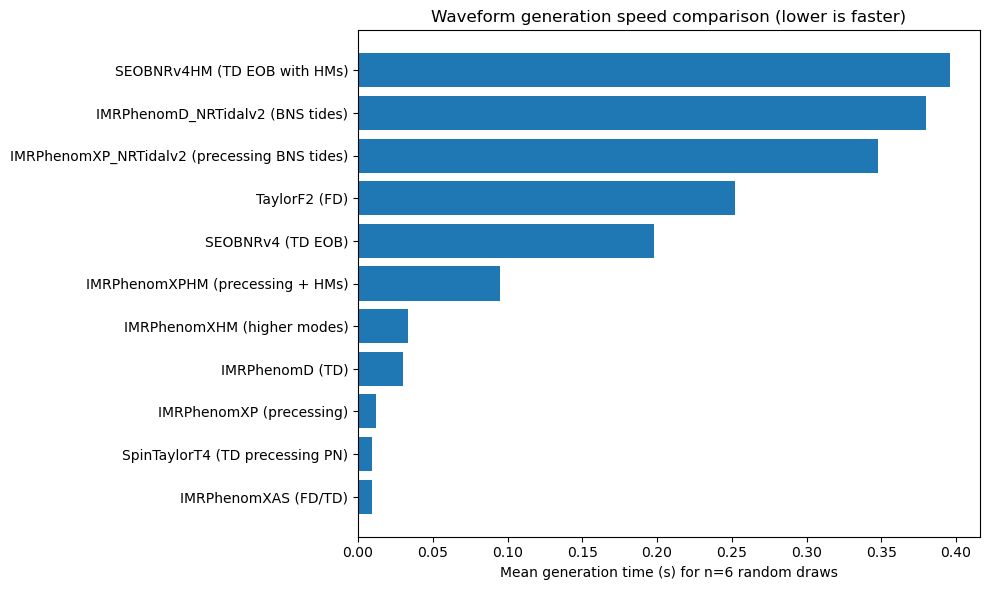

In [6]:
# --- Timing benchmarks ---------------------------------------------------------
import pandas as pd

results = []
for name, gen, sampler in EXAMPLES:
    try:
        r = benchmark(lambda p: gen(p), sampler, n=6, name=name)
    except Exception as e:
        r = {"name": name, "ok": False, "n": 0, "mean_s": np.nan, "err": str(e)}
    results.append(r)

df = pd.DataFrame(results).sort_values(by="mean_s", ascending=True)
df
# Plot
plt.figure(figsize=(10,6))
ok = df[df["ok"]].copy()
plt.barh(ok["name"], ok["mean_s"])
plt.xlabel("Mean generation time (s) for n=6 random draws")
plt.title("Waveform generation speed comparison (lower is faster)")
plt.tight_layout()
plt.show()

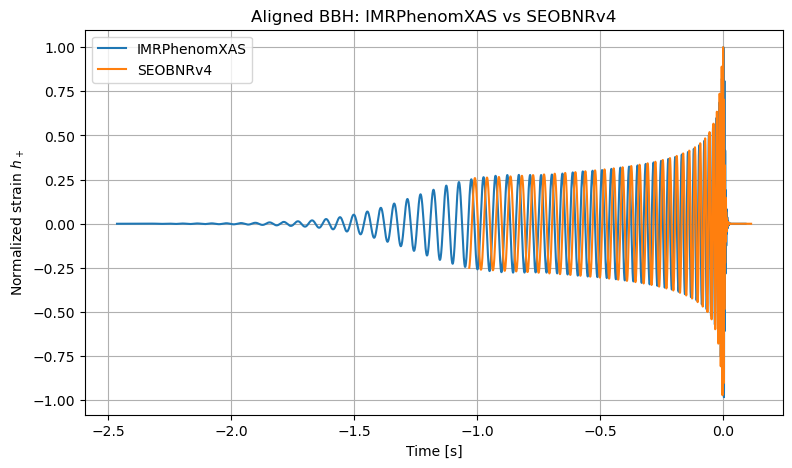

In [7]:
# --- Deep-dive comparison: Phenom vs SEOBNR for identical aligned-spin BBH ----
params = rand_aligned_bbhs()
labels = {}
for apx in ["IMRPhenomXAS", "SEOBNRv4"]:
    t, hp, hc = call_pycbc(apx, params)
    labels[apx] = (t, hp, hc)
plot_overlay(labels, title="Aligned BBH: IMRPhenomXAS vs SEOBNRv4")



## Notes, gotchas, and where to look up details

- **PyCBC interface** (`get_td_waveform`, `get_fd_waveform`, `td_approximants`, `fd_approximants`).
- **IMRPhenomX family** in LALSimulation (XAS/XHM/XP/XPHM).
- **BNS tides** in the Phenom family (e.g., `IMRPhenomD_NRTidalv2`, `IMRPhenomXAS_NRTidalv2`, `IMRPhenomXP_NRTidalv2`).
- **pySEOBNR v5** usage (class `GenerateWaveform`, methods `.generate_td_modes()`, `.generate_td_polarizations()`).
- **TEOBResumS** Python bindings (`EOBRun_module.EOBRunPy`) and gallery examples.
- **GWSurrogate** usage and models (e.g., `NRSur7dq4`, `NRHybSur3dq8`).

> Tip: to list exactly which approximants are available in your environment:
> ```python
> from pycbc.waveform import td_approximants, fd_approximants
> print(td_approximants())
> print(fd_approximants())
> ```
